# Reproduction of Cycling Task Factor SNN

In [1]:

"""
Library and utility import
"""

import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import torch
import torch.nn as nn
import zutils
import pandas as pd

In [2]:
"""
Check for GPU availability
"""
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


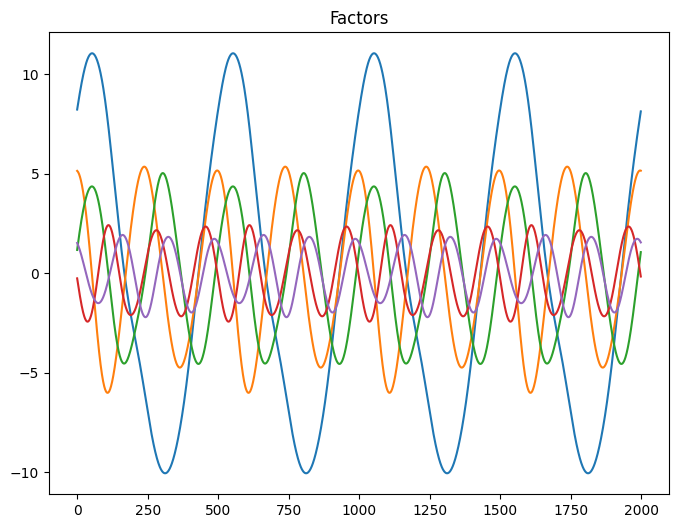

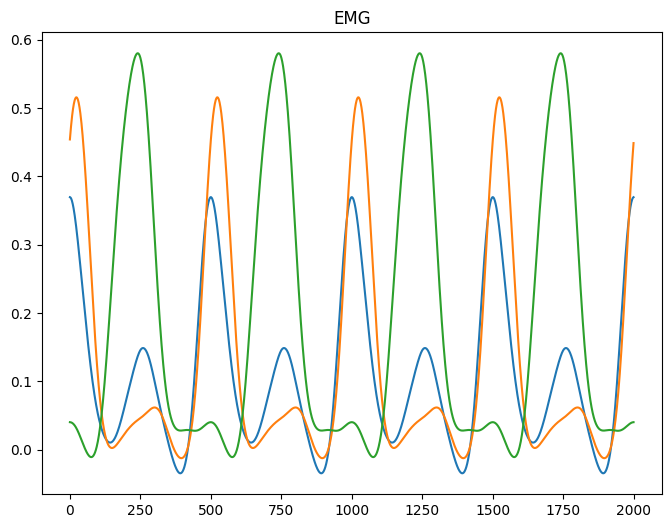

In [218]:
"""
Load in the data and move to device
"""

factors_df = pd.read_csv("./Depaq-Data/Cycling/factors.csv", header=None)
emg_df = pd.read_csv("./Depaq-Data/Cycling/emg.csv", header=None)

factors = torch.tensor(factors_df.values, dtype=torch.float)
emg = torch.tensor(emg_df.values, dtype=torch.float)

factors = factors.to(device)
emg = emg.to(device)

# Visualize the data
plt.figure(figsize=(8, 6))
plt.plot(factors[:,[1,2,3,4,5]])
plt.title("Factors")
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(emg[:,[0,1,2]])
plt.title("EMG")
plt.show()

In [219]:
# Generate more training data
n = 15
factors = factors.repeat((n, 1))  # shape (n * 2000, 12)

In [220]:
factors.size()

torch.Size([30000, 12])

In [221]:
"""
Define the SNN
"""

# Training parameters
nb_steps  = 29999
batch_size = 1
dtype = torch.float

# Network parameters
nb_inputs  = 12
nb_hidden  = 800
nb_outputs = 12
time_step = 1e-3

tau_mem = 10e-3  # Membrane voltage time constant (10ms)
tau_syn_f = 5e-3  # Synaptic voltage fast time constant (5ms)
tau_syn_s = 100e-3  # Synaptic voltage slow time constant (100ms)

# Parameters do define J_0, U, and W_in
g_f = 0.13
g_s = 0.11
g = 3.0
mu_f = -0.3
mu_s = 0


# Decay constants for discretized equations
alpha_f   = float(np.exp(-time_step/tau_syn_f))
alpha_s   = float(np.exp(-time_step/tau_syn_s))
beta    = float(np.exp(-time_step/tau_mem))

# Initialize the network weight matrices
weight_scale = 5.5*(1.0-beta)

# Hidden layer -> Hidden layer (non-factor related)
J0_FirstN = torch.empty((nb_hidden, nb_hidden), device=device, dtype=dtype, requires_grad=False)
torch.nn.init.normal_(J0_FirstN, mean=(mu_f / (nb_hidden*tau_syn_f)), std=((g_f**2) / (nb_hidden*tau_syn_f**2)))

J0_SecondN = torch.empty((nb_hidden, nb_hidden), device=device, dtype=dtype, requires_grad=False)
torch.nn.init.normal_(J0_SecondN, mean=(mu_s / (nb_hidden*tau_syn_s)), std=((g_s**2) / (nb_hidden*tau_syn_s**2)))

J_0 = torch.cat((J0_FirstN, J0_SecondN), dim=1)


# Hidden layer -> Hidden layer (factor related)
U = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=False)
torch.nn.init.uniform_(U, a=-1.0, b=1.0)
U /= g

# Input -> Hidden layer
W_in = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=dtype, requires_grad=False)
torch.nn.init.uniform_(W_in, a=-1.0, b=1.0)
W_in /= g

"""
How to initialize W_out?
"""
# Hidden layer -> factors
W_out = torch.empty((nb_outputs, 2*nb_hidden), device=device, dtype=dtype, requires_grad=False)
torch.nn.init.normal_(W_out, mean=0.0, std=0.0001) #weight_scale/np.sqrt(nb_hidden)

# Total recurrent effect: U will be fixed and W_out will be learned to decode the factors
J_fac = U @ W_out

J = J_0 + J_fac

warmup_steps = 1000  # Number of warmup steps for the network
warmup_factors = factors[:warmup_steps, :]  # Factors for warmup
# Define inputs
inputs = torch.zeros((batch_size, nb_inputs, nb_steps), device=device, dtype=dtype, requires_grad=False)
inputs[:,:,1:warmup_steps+1] = warmup_factors.T

"""
How to randomly initialize the synaptic and membrane voltages?
"""
# Initialize the synaptic and membrane voltages
syn_s = torch.empty((batch_size,nb_hidden), device=device, dtype=dtype)
torch.nn.init.normal_(syn_s, mean=0.0, std=0.0)  # weight_scale/np.sqrt(nb_hidden)

syn_f = torch.empty((batch_size,nb_hidden), device=device, dtype=dtype)
torch.nn.init.normal_(syn_f, mean=0.0, std=0.0)

syn_total = torch.cat((syn_f, syn_s), dim=1)

mem = torch.empty((batch_size,nb_hidden), device=device, dtype=dtype)
torch.nn.init.normal_(mem, mean=0.0, std=0.0)

print("init done")

init done


In [222]:
h1 = W_in.T @ inputs
h1

tensor([[[ 0.0000, -1.9353, -1.9140,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.7664,  0.6726,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.5189,  0.4665,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  1.1915,  1.1034,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  3.2778,  3.2364,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  5.1750,  5.1712,  ...,  0.0000,  0.0000,  0.0000]]])

In [223]:
# Compute the input affects on hidden layer for each time step
h1 = W_in.T @ inputs

mem_rec = []
spk_rec = []
syn_total_rec = []

P = torch.eye(2*nb_hidden) * 1000.0  # Large initial value (λ⁻¹), acts like regularization
factor_pred_rec = []

# Simulate the network warmup to learn parameters to set average spike rate
for t in range(warmup_steps):
    if t % 100 == 0:
        print(f"Time step {t}/{warmup_steps}")
    out = spike_fn(mem)
    rst = out.detach() # We do not want to backprop through the reset

    # Update synaptic fast a slow voltages
    #           Decay + Input + Spike Increment
    new_syn_f = alpha_f * syn_f + h1[:, :, t] + rst
    new_syn_s = alpha_s * syn_s + h1[:, :, t] + rst
    new_syn_total = torch.cat((new_syn_f, new_syn_s), dim=1)


    

    # Update the membrane potentials
    J_fac = U @ W_out
    #           Decay  +   Nonfactor recurrent + Factor recurrent * Reset
    new_mem = (beta*mem + syn_total @ J_0.T + syn_total @ J_fac.T)*(1.0-rst)

    mem_rec.append(mem)
    spk_rec.append(out)
    syn_total_rec.append(syn_total)
    
    # Update the state variables
    mem = new_mem
    syn_total = new_syn_total
    syn_f = new_syn_f
    syn_s = new_syn_s

mem_rec = torch.stack(mem_rec,dim=1)
spk_rec = torch.stack(spk_rec,dim=1)
syn_total_rec = torch.stack(syn_total_rec, dim=1)

# Compute V_mu to set average spike rate
v_rest = -10.0  # in mV
v_mu_bar = 10.0     # global excitatory input

uy = U @ warmup_factors.T
J0_MeanSubtracted = J_0 - torch.mean(J_0, dim=(0,1))
J0_Syn = J0_MeanSubtracted @ syn_total_rec.squeeze().T
term3 = uy + J0_Syn
term3_mean = torch.mean(term3, dim=1)

V_mu = v_rest + v_mu_bar + term3_mean



mem_rec = []
spk_rec = []
syn_total_rec = []

P = torch.eye(2*nb_hidden) * 1000.0  # Large initial value (λ⁻¹), acts like regularization
factor_pred_rec = []
# Now run the network for real
# Simulate the network warmup to learn parameters to set average spike rate
for t in range(nb_steps):
    if t % 1000 == 0:
        print(f"Time step {t}/{nb_steps}")
    memstr = mem - V_mu
    out = spike_fn(mem)
    rst = out.detach() # We do not want to backprop through the reset

    # Update synaptic fast a slow voltages
    #           Decay + Input + Spike Increment
    new_syn_f = alpha_f * syn_f + h1[:, :, t] + rst
    new_syn_s = alpha_s * syn_s + h1[:, :, t] + rst
    new_syn_total = torch.cat((new_syn_f, new_syn_s), dim=1)

    # Update the membrane potentials
    J_fac = U @ W_out
    #           Decay  +   Nonfactor recurrent + Factor recurrent * Reset
    new_mem = (beta*mem + syn_total @ J_0.T + syn_total @ J_fac.T)*(1.0-rst)

    # --- RLS UPDATE ---

    # For now, assume batch=1
    x_t = new_syn_total[0]  # shape: (2N,)
    y_t = factors[t]        # shape: (num_factors,)

    if t <nb_steps*3.4:
        Px = P @ x_t
        denom = 1.0 + x_t @ Px
        k_t = Px / denom
        e_t = y_t - W_out @ x_t
        W_out += torch.outer(e_t, k_t)
        P -= torch.outer(k_t, Px)

    factor_pred = new_syn_total @ W_out.T  # shape: (batch_size, num_factors)
    factor_pred_rec.append(factor_pred)



    mem_rec.append(mem)
    spk_rec.append(out)
    syn_total_rec.append(syn_total)
    
    # Update the state variables
    mem = new_mem
    syn_total = new_syn_total
    syn_f = new_syn_f
    syn_s = new_syn_s

mem_rec = torch.stack(mem_rec,dim=1)
spk_rec = torch.stack(spk_rec,dim=1)
syn_total_rec = torch.stack(syn_total_rec, dim=1)


factor_pred_rec = torch.stack(factor_pred_rec, dim=1)  # shape: (batch_size, time, num_factors)

Time step 0/1000
Time step 100/1000
Time step 200/1000
Time step 300/1000
Time step 400/1000
Time step 500/1000
Time step 600/1000
Time step 700/1000
Time step 800/1000
Time step 900/1000
Time step 0/29999
Time step 1000/29999
Time step 2000/29999
Time step 3000/29999
Time step 4000/29999
Time step 5000/29999
Time step 6000/29999
Time step 7000/29999
Time step 8000/29999
Time step 9000/29999
Time step 10000/29999
Time step 11000/29999
Time step 12000/29999
Time step 13000/29999
Time step 14000/29999
Time step 15000/29999
Time step 16000/29999
Time step 17000/29999
Time step 18000/29999
Time step 19000/29999
Time step 20000/29999
Time step 21000/29999
Time step 22000/29999
Time step 23000/29999
Time step 24000/29999
Time step 25000/29999
Time step 26000/29999
Time step 27000/29999
Time step 28000/29999
Time step 29000/29999


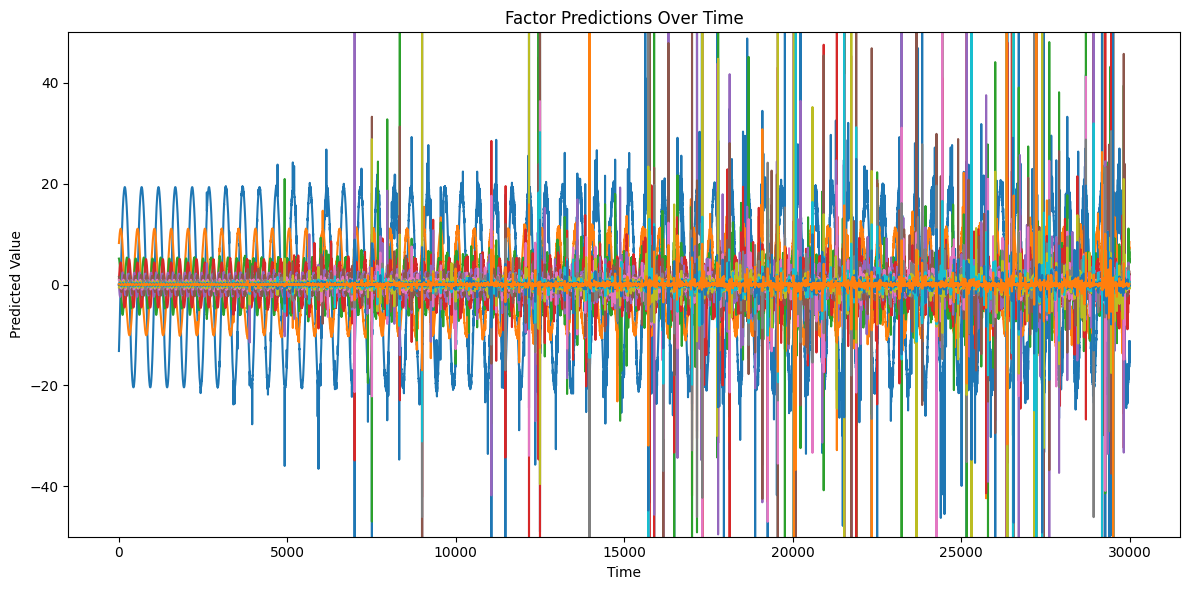

In [224]:
import matplotlib.pyplot as plt

# Remove batch dimension: (1, 1000, 12) -> (1000, 12)
factor_pred_np = factor_pred_rec.squeeze(0).detach().cpu().numpy()

# Plot each factor over time
plt.figure(figsize=(12, 6))
for i in range(factor_pred_np.shape[1]):  # loop over 12 factors
    plt.plot(factor_pred_np[:, i], label=f'Factor {i+1}')

plt.xlabel('Time')
plt.ylabel('Predicted Value')
plt.title('Factor Predictions Over Time')
plt.ylim(-50,50)
plt.tight_layout()
plt.show()

In [201]:
mem_rec[0,:,0]

tensor([-346.3518, -319.8775, -300.4856,  ...,    0.0000,    8.5555,
          21.1068])

In [203]:
spk_rec.size()

torch.Size([1, 5999, 800])

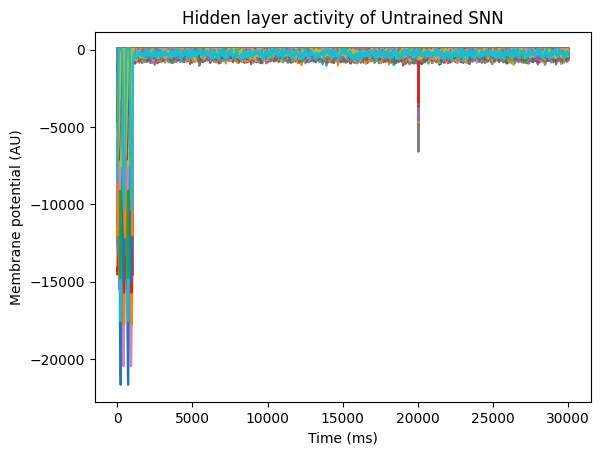

In [225]:
fig=plt.figure(dpi=100)
plot_voltage_traces(mem_rec, spk_rec)
plt.title("Hidden layer activity of Untrained SNN")
plt.ylabel("Membrane potential (AU)")
plt.xlabel("Time (ms)")
plt.show()

In [211]:
def plot_voltage_traces(mem, spk=None, dim=(1,1), spike_height=40):
    gs=GridSpec(*dim)
    if spk is not None:
        dat = 1.0*mem
        dat[spk>0.0] = spike_height
        dat = dat.detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i==0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i],sharey=a0)
        ax.plot(dat[i])
        # ax.axis("off")

    # ax.set_ylim(-50, 50)

In [ ]:
# Define the heaviside step function for the nonlinearity
def spike_fn(x):
    out = torch.zeros_like(x)
    out[x > 0] = 1.0
    return out